# Configuración

## Librerias

In [1]:
'''
!pip3 install numpy
!pip3 install matplotlib
!pip3 install tensorflow
!pip3 install numpy
'''

'\n!pip3 install numpy\n!pip3 install matplotlib\n!pip3 install tensorflow\n!pip3 install numpy\n'

In [2]:
import os
import cv2

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import gradio as gr

2023-11-13 20:02:05.790411: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-13 20:02:05.812649: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-13 20:02:05.812678: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-13 20:02:05.812696: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-13 20:02:05.817389: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-13 20:02:05.817804: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

## Constantes

In [3]:
BATCH_SIZE = 4
IMG_SIZE = (224, 224)

# Preprocesamiento

## Funciones

In [4]:
def preprocess_image(input_path, output_path, target_resolution=IMG_SIZE):

    try:
        # Load the image
        img = cv2.imread(input_path)

        try:
            img_corrected = np.power(img / 255.0, 1.5) * 255.0
        except Exception as e:
            print(f'Image {img} could not be gamma corrected due to    {e}' )

        try:
            img_contrast = cv2.convertScaleAbs(img_corrected, alpha=1.2, beta=0)
        except Exception as e:
            print(f'Image {img} could not be contrast corrected due to {e}' )

        try:
            img_resized = cv2.resize(img_contrast, target_resolution)
        except Exception as e:
            print(f'Image {img} could not be resized due to            {e}' )


        cv2.imwrite(output_path, img_resized)

    except:
        print(f'Image on {input_path} could not be loaded' )



def preprocess_images_in_directory(src_directory, dest_directory):
    # Iterate through train and validation directories
    for type in os.listdir(src_directory):
        dataset_path = os.path.join(src_directory, type)

        # Skip non-directory entries
        if not os.path.isdir(dataset_path):
            continue

        # Create corresponding directory in the destination
        dest_dataset_path = os.path.join(dest_directory, type)
        os.makedirs(dest_dataset_path, exist_ok=True)

        # Iterate through each season in the dataset
        for season in os.listdir(dataset_path):
            season_path = os.path.join(dataset_path, season)

            # Skip non-directory entries
            if not os.path.isdir(season_path):
                continue

            # Create a corresponding subdirectory in the destination directory
            dest_season_path = os.path.join(dest_dataset_path, season)
            os.makedirs(dest_season_path, exist_ok=True)

            # Iterate through each image in the season directory
            for filename in os.listdir(season_path):
                if filename.endswith(('.jpeg', '.jpg', '.png')):
                    input_path = os.path.join(season_path, filename)

                    # Generate the output path in the destination directory
                    output_path = os.path.join(dest_season_path, filename)

                    # Preprocess and save the image
                    print(f'Will now preprocess image on {type}/{season}/{filename}')
                    preprocess_image(input_path, output_path)

## Ejecucion

In [5]:
src_directory = "./static/images/estaciones_filtered"  # Adjust this to your input folder
dest_directory = "./static/images/estaciones_preprocessed"  # Adjust this to your output folder

In [6]:
#preprocess_images_in_directory(src_directory, dest_directory)

# Modelo

## Datasets desde folder

In [7]:
PATH ='./static/images/estaciones_preprocessed'
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [8]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
                                                        train_dir,
                                                        shuffle=True,
                                                        batch_size=BATCH_SIZE,
                                                        image_size=IMG_SIZE,
                                                        label_mode='categorical')

Found 152 files belonging to 4 classes.


2023-11-13 20:02:07.230618: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-11-13 20:02:07.230643: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: wandering
2023-11-13 20:02:07.230648: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: wandering
2023-11-13 20:02:07.230748: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 525.125.6
2023-11-13 20:02:07.230762: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 525.125.6
2023-11-13 20:02:07.230765: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 525.125.6


In [9]:
testing_dataset = tf.keras.utils.image_dataset_from_directory(
                                                        validation_dir,
                                                        shuffle=True,
                                                        batch_size=BATCH_SIZE,
                                                        image_size=IMG_SIZE,
                                                        label_mode='categorical')

Found 32 files belonging to 4 classes.


## Cardinalidad

In [10]:
val_batches = tf.data.experimental.cardinality(train_dataset)
print(f'Number of batches: {val_batches}')

Number of batches: 38


In [11]:
val_batches = tf.data.experimental.cardinality(testing_dataset)
print(f'Number of batches: {val_batches}')

Number of batches: 8


## División en validación y pruebas

In [12]:
test_dataset = testing_dataset.take(val_batches // 5)
validation_dataset = testing_dataset.skip(val_batches // 5)

In [13]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 7
Number of test batches: 1


# Modelo

## Datasets desde folder

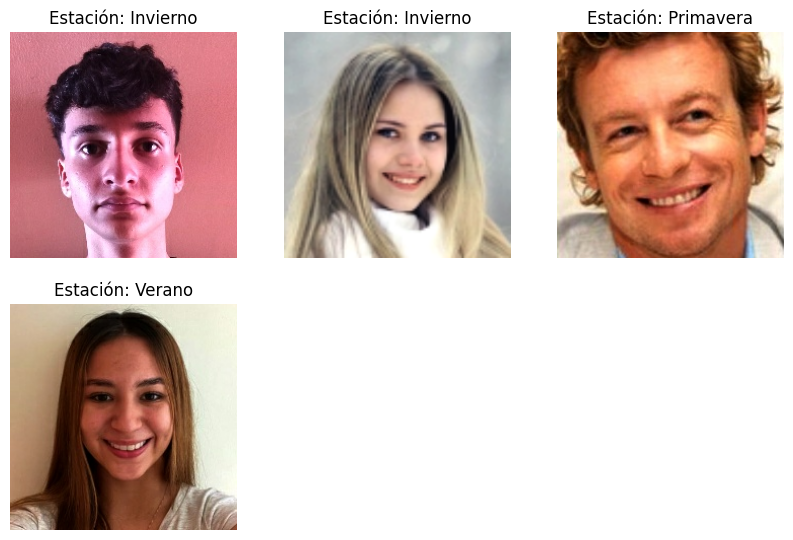

In [14]:
def estaciones(codigo):
    if (codigo == [0., 0., 1., 0.]).all():
        return 'Primavera'
    elif (codigo == [0., 1., 0., 0.]).all():
        return 'Verano'
    elif (codigo == [0., 0., 0., 1.]).all():
        return 'Otoño'
    elif (codigo == [1., 0., 0., 0.]).all():
        return 'Invierno'

class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(4):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")
    estacion_codigo = estaciones(labels[i].numpy())
    plt.title(f'Estación: {estacion_codigo}')

In [15]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  #tf.keras.layers.RandomBrightness([-0.4,0.4]),
  tf.keras.layers.RandomZoom(height_factor=(-0.05, 0.2) ),
])

(224, 224, 3)


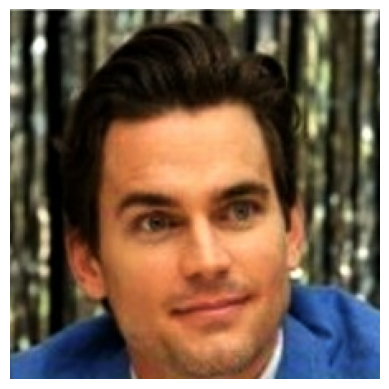

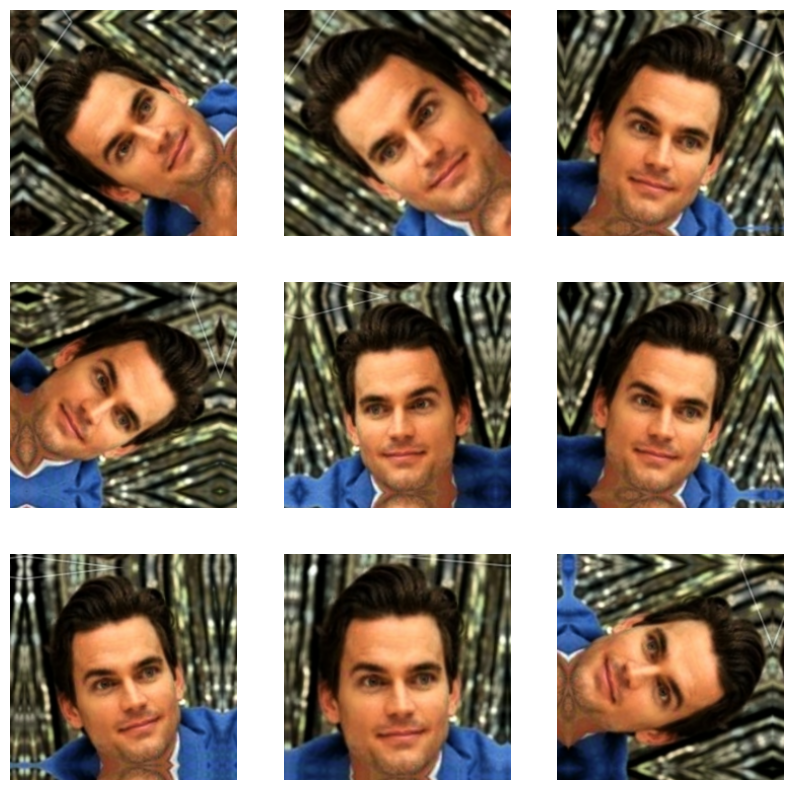

In [16]:
for image, _ in train_dataset.take(1):
  plt.figure()
  first_image = image[0]
  plt.imshow(first_image / 255)
  plt.axis('off')
  print(first_image.shape)
  plt.figure(figsize=(10, 10))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [17]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [18]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

In [19]:
print(base_model.summary())
#tf.keras.utils.plot_model(base_model, to_file='model.png')

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [20]:
tf.keras.utils.plot_model(base_model, to_file='model.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [21]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(4, 7, 7, 1280)


In [22]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(4, 1280)


In [23]:
prediction_layer = tf.keras.layers.Dense(4)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(4, 4)


In [27]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = rescale(x)
x = base_model(x, training=False)
x = global_average_layer(x)
#x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [28]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
initial_epochs = 20

loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

7/7 [==============================] - 1s 29ms/step - loss: 0.6869 - accuracy: 0.2143
initial loss: 0.69
initial accuracy: 0.21


In [30]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/20


38/38 [==============================] - 3s 35ms/step - loss: 0.6841 - accuracy: 0.2039 - val_loss: 0.5783 - val_accuracy: 0.2143
Epoch 2/20
38/38 [==============================] - 1s 32ms/step - loss: 0.6291 - accuracy: 0.2171 - val_loss: 0.5972 - val_accuracy: 0.2857
Epoch 3/20
38/38 [==============================] - 1s 32ms/step - loss: 0.6021 - accuracy: 0.2697 - val_loss: 0.5783 - val_accuracy: 0.3571
Epoch 4/20
38/38 [==============================] - 1s 33ms/step - loss: 0.5835 - accuracy: 0.3026 - val_loss: 0.5749 - val_accuracy: 0.3214
Epoch 5/20
38/38 [==============================] - 1s 32ms/step - loss: 0.5814 - accuracy: 0.2566 - val_loss: 0.5770 - val_accuracy: 0.3571
Epoch 6/20
38/38 [==============================] - 1s 32ms/step - loss: 0.5611 - accuracy: 0.3289 - val_loss: 0.5678 - val_accuracy: 0.3214
Epoch 7/20
38/38 [==============================] - 1s 33ms/step - loss: 0.5540 - accuracy: 0.3355 - val_loss: 0.5429 - val_accuracy: 0.4286
Epoch 8/20
38/38 [======

Text(0.5, 1.0, 'Training and Validation Accuracy')

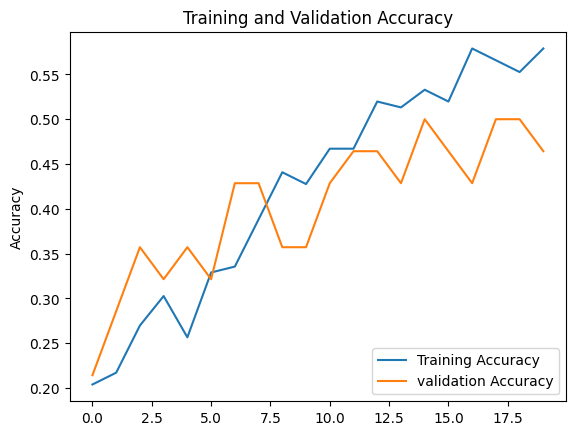

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training Accuracy','validation Accuracy'],loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')


In [32]:
model.save('./model/final_model.h5')

/home/vagabond/.pyenv/versions/3.11.3/envs/IA/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [33]:
base_model.trainable = True

capas_bloqueadas =len(base_model.layers)- 10

for layer in base_model.layers[:capas_bloqueadas]:
  layer.trainable = False

In [34]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [35]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 rescaling (Rescaling)       multiple                  0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 4)                 5124

In [36]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 20/40
38/38 [==============================] - 4s 52ms/step - loss: 0.4590 - accuracy: 0.5921 - val_loss: 0.5312 - val_accuracy: 0.4286
Epoch 21/40
38/38 [==============================] - 1s 38ms/step - loss: 0.4253 - accuracy: 0.6513 - val_loss: 0.5682 - val_accuracy: 0.3571
Epoch 22/40
38/38 [==============================] - 1s 39ms/step - loss: 0.4263 - accuracy: 0.5855 - val_loss: 0.5617 - val_accuracy: 0.4643
Epoch 23/40
38/38 [==============================] - 1s 39ms/step - loss: 0.4069 - accuracy: 0.6250 - val_loss: 0.5571 - val_accuracy: 0.4286
Epoch 24/40
38/38 [==============================] - 1s 39ms/step - loss: 0.3903 - accuracy: 0.6645 - val_loss: 0.5304 - val_accuracy: 0.4286
Epoch 25/40
38/38 [==============================] - 1s 35ms/step - loss: 0.4029 - accuracy: 0.6118 - val_loss: 0.5896 - val_accuracy: 0.4286
Epoch 26/40
38/38 [==============================] - 1s 37ms/step - loss: 0.3719 - accuracy: 0.7039 - val_loss: 0.5312 - val_accuracy: 0.4286
Epoch 

Text(0.5, 1.0, 'Training and Validation Accuracy')

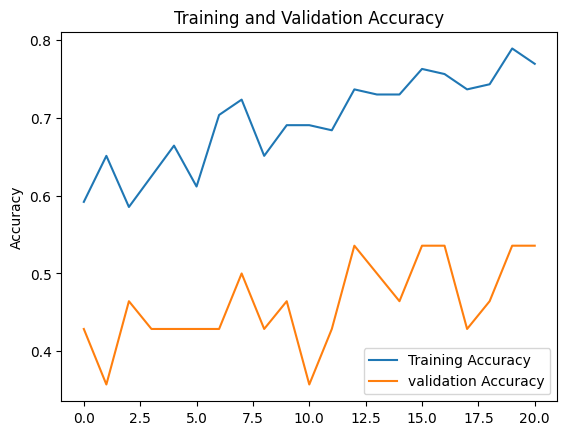

In [37]:
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.legend(['Training Accuracy','validation Accuracy'],loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

In [38]:
model.save('./model/final_model.h5')

Predictions:
 [1 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0]
Labels:
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


TypeError: only integer scalar arrays can be converted to a scalar index

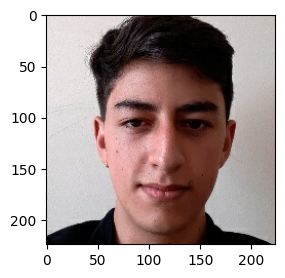

In [44]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(14, 28))
for i in range(32):
  ax = plt.subplot(8, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(f' p:{class_names[predictions[i]]}, l:{class_names[label_batch[i]]}')
  plt.axis("off")

In [ ]:

inception_net = tf.keras.models.load_model('./model/final_model.h5')

labels = ['gato','perro']
def classify_image(inp):
    inp = inp.reshape((-1, 224, 224, 3))
    prediction = inception_net.predict(inp).flatten()
    prediction = tf.nn.sigmoid(prediction)
    prediction = tf.where(prediction < 0.5, 0, 1)
    return labels[int(prediction)]

image = gr.inputs.Image(shape=(224, 224), source="upload")
label = gr.outputs.Label()

gr.Interface(
    fn=classify_image, inputs=image, outputs=label, interpretation="default"
).launch(debug=True)

ModuleNotFoundError: ignored

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=99412c2e-f061-48b1-b330-0dfd48ccdcce' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>